- 라이브러리

In [1]:
import cv2
import numpy as np
import gc
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import json
from sklearn.metrics import classification_report, roc_curve, auc


%matplotlib inline

- GPU 사용

In [2]:
def check_cuda_pytorch():
    if torch.cuda.is_available():
        print(f"CUDA is available! Device count: {torch.cuda.device_count()}")
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    else:
        print("CUDA is not available.")

check_cuda_pytorch()

CUDA is available! Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3090


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

- 데이터 불러오기

In [4]:
# JSON 파일에서 데이터 불러오기
backup_file = 'backup_data.json'

with open(backup_file, 'r') as f:
    raw_data = json.load(f)


- 데이터 전처리

In [5]:
class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list :
            self.y.append(dic['key'])
            self.X.append(dic['value'])

    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
        return len(self.X)

In [6]:
#train, validation, test set를 8, 1, 1비율로 나누기
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(raw_data) * split_ratio[0])
val_len = int(len(raw_data) * split_ratio[1])
test_len = len(raw_data) - train_len - val_len

print('{}, {}, {}'.format(train_len, val_len, test_len))

640, 80, 80


In [7]:
#데이터 로드하기
BATCH_SIZE=8
train_dataset = MyDataset(raw_data)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

- 모델 설계  
lstm1(64) - lstm2(128) - lstm3(256) - Dropout1(0.2) - lstm4(128) -  lstm5(64) - lstm6(32) - Dropout2(0.2) - lstm7(16) - Dense(2)

In [8]:
# LSTM
class skeleton_LSTM(nn.Module):
    def __init__(self):
        super(skeleton_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=len(attention_dot) * 2, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm4 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm7 = nn.LSTM(input_size=32, hidden_size=16, batch_first=True)
        self.fc = nn.Linear(16,2)

    def forward(self, x) :
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:,-1,:])

        return x

In [9]:
#BidirectionalLSTM
class BidirectionalLSTM(nn.Module):
    def __init__(self):
        super(BidirectionalLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=len(attention_dot) * 2, hidden_size=64, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=256, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size=64, batch_first=True, bidirectional=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size=32, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.2)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size=16, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:, -1, :])
        return x


In [10]:
#GRU
class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size=len(attention_dot) * 2, hidden_size=64, batch_first=True)
        self.gru2 = nn.GRU(input_size=64, hidden_size=128, batch_first=True)
        self.gru3 = nn.GRU(input_size=128, hidden_size=256, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru4 = nn.GRU(input_size=256, hidden_size=128, batch_first=True)
        self.gru5 = nn.GRU(input_size=128, hidden_size=64, batch_first=True)
        self.gru6 = nn.GRU(input_size=64, hidden_size=32,  batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.gru7 = nn.GRU(input_size=32, hidden_size=16, batch_first=True)
        self.fc = nn.Linear(16, 2)

    def forward(self, x):
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        x = self.dropout1(x)
        x, _ = self.gru4(x)
        x, _ = self.gru5(x)
        x, _ = self.gru6(x)
        x = self.dropout2(x)
        x, _ = self.gru7(x)
        x = self.fc(x[:, -1, :])
        return x


- 모델 컴파일

In [11]:
# LSTM(skeleton_LSTM)

def init_model_LSTM():
    global net, loss_fn, optim
    net = skeleton_LSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)

# BidirectionalLSTM

def init_model_BDL():
    global net, loss_fn, optim
    plt.rc('font', size = 10)
    net = BidirectionalLSTM().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)
    
# GRU(GRUModel)

def init_model_GRU():
    global net, loss_fn, optim
    plt.rc('font', size = 10)
    net = GRUModel().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)

- 기타 함수 정의

In [12]:
# 학습 알고리즘
def epoch(data_loader, mode = 'train'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc = [], []

    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            net.eval()

        result = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출( _ : 값 부분은 필요 없음, out : index 중 가장 큰 하나의 데이터)

        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록

        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기를 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행

        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TM)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록

    # 역전파 학습 후 Epoch 카운터 += 1
    if mode=='train':
        epoch_cnt += 1

    gc.collect()

    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label 값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

In [13]:
def get_predictions(model, data_loader):
    model.eval()  # 모델을 평가 모드로 설정
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스 선택
            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())

    return predictions, ground_truth

In [14]:
#ROC curve 성능 지표
def roc_get_predictions(model, data_loader):
    model.eval()
    predictions = []
    ground_truth = []
    probs = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            probs_batch = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(probs_batch, dim=1)
            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())
            probs.extend(probs_batch.cpu().numpy())

    return np.array(predictions), np.array(ground_truth), np.array(probs)

- 하이퍼파라미터 정의

In [15]:
EPOCH = 300
BATCH_SIZE = 8
PATIENCE = 50  # Early stopping의 기준이 되는 epoch 수
start_dot = 0
attention_dot = [n for n in range(start_dot, 29)]
epoch_cnt=0

- LSTM 실행

In [16]:
# 모델, epoch, log 초기화
init_model_LSTM()
maximum_epoch = EPOCH

# Early stopping 관련 변수 설정
best_vacc = 0
patience_counter = 0

while epoch_not_finished():
    tloss, tacc = epoch(train_loader, mode='train')
    
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode='val')

    print(f'Epoch {epoch_cnt} | Train Loss = {tloss:.2f} | Train Acc = {tacc:.2f} | Val Loss = {vloss:.2f} |   Val Acc = {vacc:.2f}')

    # Early stopping 조건 검사
    if vacc > best_vacc:
        best_vacc = vacc
        patience_counter = 0
        
    else:
        patience_counter += 1

    # Patience 초과시 훈련 종료
    if patience_counter >= PATIENCE:
        print("Early stopping triggered")
        break

print('\n Training completed!')


Epoch 1 | Train Loss = 0.69 | Train Acc = 0.51 | Val Loss = 0.69 |   Val Acc = 0.51
Epoch 2 | Train Loss = 0.69 | Train Acc = 0.51 | Val Loss = 0.69 |   Val Acc = 0.51
Epoch 3 | Train Loss = 0.69 | Train Acc = 0.54 | Val Loss = 0.69 |   Val Acc = 0.66
Epoch 4 | Train Loss = 0.68 | Train Acc = 0.62 | Val Loss = 0.66 |   Val Acc = 0.66
Epoch 5 | Train Loss = 0.63 | Train Acc = 0.68 | Val Loss = 0.64 |   Val Acc = 0.66
Epoch 6 | Train Loss = 0.61 | Train Acc = 0.69 | Val Loss = 0.63 |   Val Acc = 0.66
Epoch 7 | Train Loss = 0.58 | Train Acc = 0.71 | Val Loss = 0.61 |   Val Acc = 0.69
Epoch 8 | Train Loss = 0.56 | Train Acc = 0.72 | Val Loss = 0.60 |   Val Acc = 0.72
Epoch 9 | Train Loss = 0.54 | Train Acc = 0.73 | Val Loss = 0.59 |   Val Acc = 0.75
Epoch 10 | Train Loss = 0.53 | Train Acc = 0.74 | Val Loss = 0.59 |   Val Acc = 0.76
Epoch 11 | Train Loss = 0.52 | Train Acc = 0.74 | Val Loss = 0.58 |   Val Acc = 0.74
Epoch 12 | Train Loss = 0.52 | Train Acc = 0.75 | Val Loss = 0.57 |   Val 

In [17]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc.: 0.8125
Test Loss: 0.5086


In [18]:
# Test 데이터셋에 대한 예측과 실제값 가져오기
test_predictions, test_ground_truth = get_predictions(net, test_loader)

# classification_report를 사용하여 F1 점수 계산
report = classification_report(test_ground_truth, test_predictions)
print(report)


              precision    recall  f1-score   support

           0       0.78      0.93      0.85        45
           1       0.88      0.66      0.75        35

    accuracy                           0.81        80
   macro avg       0.83      0.80      0.80        80
weighted avg       0.82      0.81      0.81        80



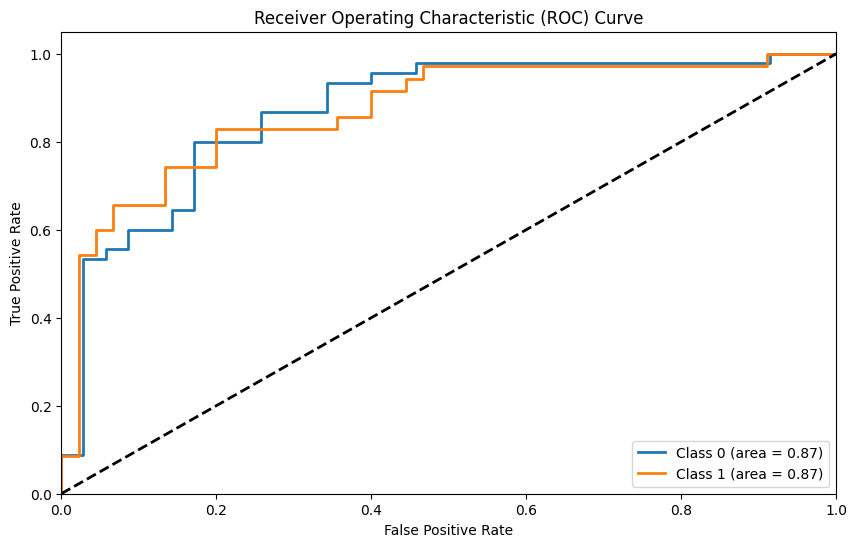

In [19]:
# Ensure net (your model) and test_loader (your test DataLoader) are defined correctly
test_predictions, test_ground_truth, test_probs = roc_get_predictions(net, test_loader)



# Determine the number of classes
num_classes = 2  # Adjust based on your problem

plt.figure(figsize=(10, 6))

for class_idx in range(num_classes):
    fpr, tpr, _ = roc_curve(test_ground_truth == class_idx, test_probs[:, class_idx])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_idx} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


- Bidirectional LSTM 실행

In [20]:
# 모델, epoch, log 초기화
init_model_BDL()
maximum_epoch = EPOCH

# Early stopping 관련 변수 설정
best_vacc = 0
patience_counter = 0

while epoch_not_finished():
    tloss, tacc = epoch(train_loader, mode='train')
    
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode='val')

    print(f'Epoch {epoch_cnt} | Train Loss = {tloss:.2f} | Train Acc = {tacc:.2f} | Val Loss = {vloss:.2f} |   Val Acc = {vacc:.2f}')

    # Early stopping 조건 검사
    if vacc > best_vacc:
        best_vacc = vacc
        patience_counter = 0
        
    else:
        patience_counter += 1

    # Patience 초과시 훈련 종료
    if patience_counter >= PATIENCE:
        print("Early stopping triggered")
        break

print('\n Training completed!')


Epoch 143 | Train Loss = 0.69 | Train Acc = 0.51 | Val Loss = 0.69 |   Val Acc = 0.51
Epoch 144 | Train Loss = 0.69 | Train Acc = 0.53 | Val Loss = 0.68 |   Val Acc = 0.71
Epoch 145 | Train Loss = 0.66 | Train Acc = 0.65 | Val Loss = 0.63 |   Val Acc = 0.70
Epoch 146 | Train Loss = 0.64 | Train Acc = 0.66 | Val Loss = 0.63 |   Val Acc = 0.69
Epoch 147 | Train Loss = 0.66 | Train Acc = 0.62 | Val Loss = 0.60 |   Val Acc = 0.72
Epoch 148 | Train Loss = 0.58 | Train Acc = 0.74 | Val Loss = 0.62 |   Val Acc = 0.69
Epoch 149 | Train Loss = 0.56 | Train Acc = 0.74 | Val Loss = 0.58 |   Val Acc = 0.72
Epoch 150 | Train Loss = 0.55 | Train Acc = 0.75 | Val Loss = 0.59 |   Val Acc = 0.69
Epoch 151 | Train Loss = 0.54 | Train Acc = 0.75 | Val Loss = 0.55 |   Val Acc = 0.72
Epoch 152 | Train Loss = 0.51 | Train Acc = 0.75 | Val Loss = 0.55 |   Val Acc = 0.70
Epoch 153 | Train Loss = 0.51 | Train Acc = 0.76 | Val Loss = 0.53 |   Val Acc = 0.74
Epoch 154 | Train Loss = 0.51 | Train Acc = 0.78 | Val

In [21]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc.: 0.7375
Test Loss: 0.5716


In [22]:
# Test 데이터셋에 대한 예측과 실제값 가져오기
test_predictions, test_ground_truth = get_predictions(net, test_loader)

# classification_report를 사용하여 F1 점수 계산
report = classification_report(test_ground_truth, test_predictions)
print(report)


              precision    recall  f1-score   support

           0       0.83      0.67      0.74        45
           1       0.66      0.83      0.73        35

    accuracy                           0.74        80
   macro avg       0.75      0.75      0.74        80
weighted avg       0.76      0.74      0.74        80



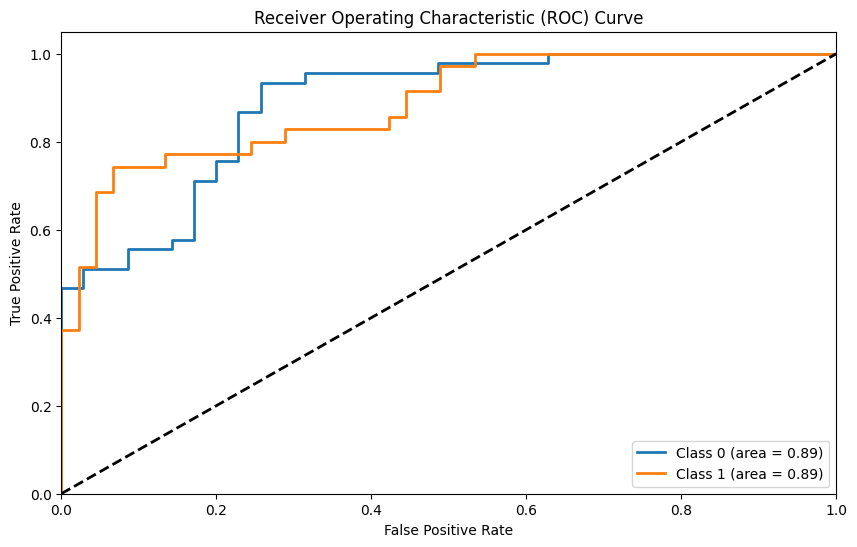

In [23]:
# Ensure net (your model) and test_loader (your test DataLoader) are defined correctly
test_predictions, test_ground_truth, test_probs = roc_get_predictions(net, test_loader)



# Determine the number of classes
num_classes = 2  # Adjust based on your problem

plt.figure(figsize=(10, 6))

for class_idx in range(num_classes):
    fpr, tpr, _ = roc_curve(test_ground_truth == class_idx, test_probs[:, class_idx])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_idx} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


- GRU Model 실행

In [16]:
# 모델, epoch, log 초기화
init_model_GRU()
maximum_epoch = EPOCH

# Early stopping 관련 변수 설정
best_vacc = 0
patience_counter = 0

while epoch_not_finished():
    tloss, tacc = epoch(train_loader, mode='train')
    
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode='val')

    print(f'Epoch {epoch_cnt} | Train Loss = {tloss:.2f} | Train Acc = {tacc:.2f} | Val Loss = {vloss:.2f} |   Val Acc = {vacc:.2f}')

    # Early stopping 조건 검사
    if vacc > best_vacc:
        best_vacc = vacc
        patience_counter = 0
        
    else:
        patience_counter += 1

    # Patience 초과시 훈련 종료
    if patience_counter >= PATIENCE:
        print("Early stopping triggered")
        break

print('\n Training completed!')


Epoch 1 | Train Loss = 0.69 | Train Acc = 0.52 | Val Loss = 0.69 |   Val Acc = 0.54
Epoch 2 | Train Loss = 0.66 | Train Acc = 0.63 | Val Loss = 0.61 |   Val Acc = 0.65
Epoch 3 | Train Loss = 0.54 | Train Acc = 0.74 | Val Loss = 0.52 |   Val Acc = 0.74
Epoch 4 | Train Loss = 0.52 | Train Acc = 0.75 | Val Loss = 0.59 |   Val Acc = 0.70
Epoch 5 | Train Loss = 0.51 | Train Acc = 0.75 | Val Loss = 0.56 |   Val Acc = 0.72
Epoch 6 | Train Loss = 0.50 | Train Acc = 0.77 | Val Loss = 0.51 |   Val Acc = 0.72
Epoch 7 | Train Loss = 0.49 | Train Acc = 0.77 | Val Loss = 0.51 |   Val Acc = 0.72
Epoch 8 | Train Loss = 0.48 | Train Acc = 0.78 | Val Loss = 0.52 |   Val Acc = 0.72
Epoch 9 | Train Loss = 0.48 | Train Acc = 0.78 | Val Loss = 0.52 |   Val Acc = 0.71
Epoch 10 | Train Loss = 0.47 | Train Acc = 0.78 | Val Loss = 0.52 |   Val Acc = 0.71
Epoch 11 | Train Loss = 0.47 | Train Acc = 0.79 | Val Loss = 0.52 |   Val Acc = 0.71
Epoch 12 | Train Loss = 0.46 | Train Acc = 0.79 | Val Loss = 0.51 |   Val 

In [17]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc.: 0.8375
Test Loss: 0.4249


In [18]:
# Test 데이터셋에 대한 예측과 실제값 가져오기
test_predictions, test_ground_truth = get_predictions(net, test_loader)

# classification_report를 사용하여 F1 점수 계산
report = classification_report(test_ground_truth, test_predictions)
print(report)


              precision    recall  f1-score   support

           0       0.88      0.76      0.82        38
           1       0.81      0.90      0.85        42

    accuracy                           0.84        80
   macro avg       0.84      0.83      0.84        80
weighted avg       0.84      0.84      0.84        80



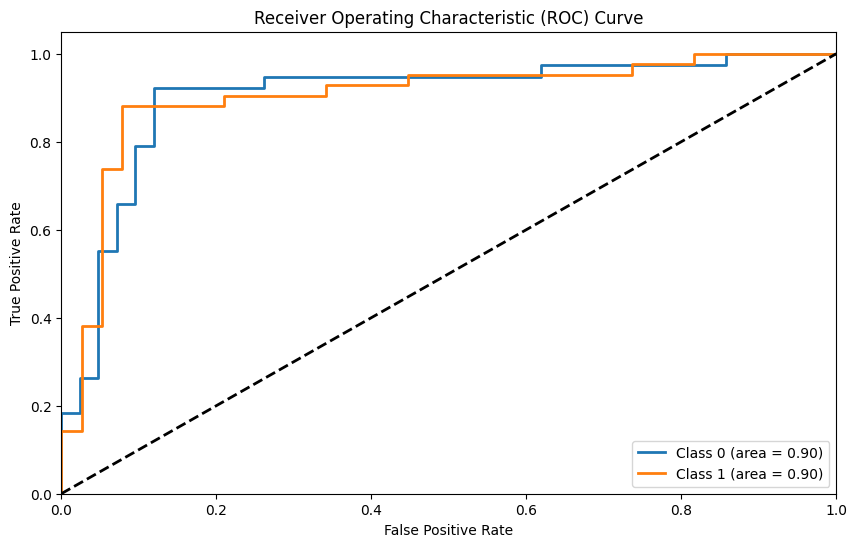

In [19]:
# Ensure net (your model) and test_loader (your test DataLoader) are defined correctly
test_predictions, test_ground_truth, test_probs = roc_get_predictions(net, test_loader)



# Determine the number of classes
num_classes = 2  # Adjust based on your problem

plt.figure(figsize=(10, 6))

for class_idx in range(num_classes):
    fpr, tpr, _ = roc_curve(test_ground_truth == class_idx, test_probs[:, class_idx])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_idx} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


- 모델 저장

In [30]:
# 모델 저장하기
PATH = 'C:/Users/mwj05/OneDrive/바탕 화면/contest/'
model_name = 'YOLO_LSTM.pt'
torch.save(net.state_dict(), PATH + model_name)

- 1분 원본 영상으로 모델 테스트 하기

In [31]:
# 영상 resize 및 추출
test_video_name = 'C_3_13_4_BU_SMB_08-28_16-44-48_CA_RGB_DF2_M1'
test_video_path = f'C:/Users/mwj05/OneDrive/바탕 화면/contest/test/{test_video_name}.mp4'
cv2.destroyAllWindows()
cap = cv2.VideoCapture(test_video_path)
img_list = []

if cap.isOpened():

    while True:
        ret, img = cap.read()
        if ret:
            img = cv2.resize(img, (640, 640))
            img_list.append(img)
            # cv2_imshow(img)
            # cv2.waitKey(1)
        else:
            break

cap.release()
cv2.destroyAllWindows()

print('저장된 frame의 개수: {}'.format(len(img_list)))

In [32]:
"""Yolov5 + Mediapipe Version"""

net.eval()

length = 30 # frame 상태를 표시할 길이
out_img_list = []
dataset = []
status = 'None'
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1, enable_segmentation=False, min_detection_confidence=n_CONFIDENCE)
print('시퀀스 데이터 분석 중...')

xy_list_list = []
for img in tqdm(img_list):
    res = yolo_model(img)
    res_refine = res.pandas().xyxy[0].values

    nms_human = len(res_refine)
    if nms_human > 0:
        for bbox in res_refine:
            xx1, yy1, xx2, yy2 = int(bbox[0])-10, int(bbox[1]), int(bbox[2])+10, int(bbox[3])
            if xx1 < 0:
                xx1 = 0
            elif xx2 > 639:
                xx2 = 639
            if yy1 < 0:
                yy1 = 0
            elif yy2 > 639:
                yy2 = 639

            start_point = (xx1, yy1)
            end_point = (xx2, yy2)
            if bbox[4] > y_CONFIDENCE:
                img = cv2.rectangle(img, start_point, end_point, (0, 0, 255), 2)

                c_img = img[yy1:yy2, xx1:xx2]
                results = pose.process(cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB)) # Yolo 바운딩 box 안에서 landmark dot 추출
                if not results.pose_landmarks: continue
                xy_list = []
                idx = 0
                draw_line_dic = {}
                for x_and_y in results.pose_landmarks.landmark:
                    if idx in attention_dot:
                        xy_list.append(x_and_y.x)
                        xy_list.append(x_and_y.y)
                        x, y = int(x_and_y.x*(xx2-xx1)), int(x_and_y.y*(yy2-yy1))
                        draw_line_dic[idx] = [x, y]
                    idx += 1

                xy_list_list.append(xy_list)
                for line in draw_line:
                    x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
                    x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
                    c_img = cv2.line(c_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

                if len(xy_list_list) == length:
                    dataset = []
                    dataset.append({'key' : 0, 'value' : xy_list_list})
                    dataset = MyDataset(dataset)
                    dataset = DataLoader(dataset)
                    xy_list_list = []

                    for data, label in dataset:
                        data = data.to(device)
                        with torch.no_grad():
                            result = net(data)
                            _, out = torch.max(result, 1)
                            if out.item() == 0: status = 'Normal'
                            else: status = 'Fight'

    cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
    out_img_list.append(img)

In [33]:
# 테스트 원본 영상 내보내기
filename = './output_13-4B.mp4'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 3
frameSize = (640, 640)
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, frameSize, isColor)
for out_img in out_img_list:
    out.write(out_img)
out.release()